In [1]:
%matplotlib inline
import calendar
import configparser
import glob
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get API key for HydAPI
api_key = nivapy.da.authenticate_nve_hydapi()

# Long-term trends in annual temperature

As part of reporting to Miljødirektoratet, Øyvind would like to estimate long-term trends in annual water temperature for the main rivers in Elveovervåkingsprogrammet. Based on NVE Atlas, the following temperature records are available:

In [2]:
stn_xlsx = r"/home/jovyan/shared/common/elveovervakingsprogrammet/temperature_data/long_term_trends/nve_temp_trends_stns.xlsx"
stn_df = pd.read_excel(stn_xlsx, sheet_name="Sheet1")
stn_df

,station_id,station_code,station_name,nve_id,nve_name,start
0,29617,ØSTEGLO,Glomma ved Sarpsfoss,2.1087.0,Glomma ovf. Sarpsfossen,2007-09-21
1,36225,OSLEALN,Alna,NaN,NaN,NaT
2,29612,BUSEDRA,Drammenselva,12.298.0,Drammenselva v/Døvikfoss,1986-12-09
3,29615,VESENUM,Numedalslågen,15.115.0,Numedalslågen v/Brufoss,1984-11-15
4,29613,TELESKI,Skienselva,16.207.0,Skienselva ndf. Norsjø,1966-10-13
5,30019,AAGEVEG,Vegårdselva,NaN,NaN,NaT
6,29614,VAGEOTR,Otra,21.79.0,Otra v/Mosby,1986-01-02
7,29832,ROGEBJE,Bjerkreimselva,27.29.0,Bjerkreimselvi v/Bjerkreim,1986-04-24
8,29783,ROGEORR,Orreelva,NaN,NaN,NaT
9,29837,ROGEVIK,Vikedalselva,38.2.0,Vikedalselva utløp,1985-10-13


Øyvind has suggested we consider those stations with records beginning **before 1995** (see e-mail received 29.10.2018 at 08.41 for details). I will attempt to download these directly using HydAPI. 

**Note:** We need to take care when calculating temperature averages from years with partial data (because the seasonal variation in temperature is obviously very strong). In the code below, I have created a user-defined parameter called `prop` which represents the proportion of the year that must have data in order to be included in the analysis. I've set this to 0.75 as a starting point i.e. there must be at least 274 ($= 0.75 \times 365$) non-null temperature measurements in a year for it to be included.

## 1. Search stations in HydAPI

In [3]:
# Final year of interest
year = 2023

# Proportion of year with daily values for year to be used in the analysis
prop = 0.9

# Output
png_fold = f"/home/jovyan/shared/common/elveovervakingsprogrammet/temperature_data/long_term_trends/to_{year}/png/prop_{int(prop*100)}"

# Output Excel file
out_xlsx = f"/home/jovyan/shared/common/elveovervakingsprogrammet/temperature_data/long_term_trends/to_{year}/long_term_temp_trends_prop_{int(prop*100)}.xlsx"

In [4]:
# Station with data before 1995
stn_df = stn_df.query("start < '1995-01-01'")
# stn_df = stn_df.dropna(subset=['nve_id'])

# Get stations from HydAPI
nve_stn_df = nivapy.da.get_nve_hydapi_stations(api_key=api_key)
nve_stn_ids = stn_df["nve_id"].tolist()
nve_stn_df = nve_stn_df.query("station_id in @nve_stn_ids")

print(f"{len(nve_stn_df)} out of {len(nve_stn_ids)} stations found in HydAPI.")
if len(nve_stn_df) != len(nve_stn_ids):
    not_found = set(nve_stn_ids) - set(nve_stn_df["station_id"].tolist())
    print("The following stations could not be identified:")
    print(not_found)

nve_stn_df

13 out of 14 stations found in HydAPI.
The following stations could not be identified:
{'16.207.0'}


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
152,12.298.0,Drammenselva v/Døvikfoss kraftstasjon,59.88580,9.90887,215237,6649648,20,Drammensvassdraget,3316,Modum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
253,121.62.0,Orkla v/Merk bru,62.90437,9.80669,236297,6985584,204,Orkla,5022,Rennebu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
375,15.115.0,Numedalslågen v/Brufoss,59.42728,9.99187,216019,6598328,51,Numedalslågen,3909,Larvik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
412,151.32.0,Vefsna v/Laksfors,65.62244,13.29067,421282,7278897,44,Vefsna,1825,Grane,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
722,196.43.0,Målselva ovf. Barduelva,69.03526,18.65517,645878,7662641,22,Målselvvassdraget,5524,Målselv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1061,21.79.0,Otra v/Mosby,58.20734,7.92995,84984,6473601,24,Otra,4204,Kristiansand,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1082,212.68.0,Altaelva v/Gargia,69.83170,23.48494,825580,7769785,46,Altavassdraget,5601,Alta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1143,234.19.0,Tana ovf. Polmakelva,70.07205,28.05574,993323,7827032,18,Tana,5628,Tana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1162,246.11.0,Pasvikelva v/Skogfoss kraftstasjon,69.37351,29.69533,1072959,7765252,40,Pasvikelva,5605,Sør-Varanger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1223,27.29.0,Bjerkreimselvi v/Bjerkreim,58.58360,6.07469,-17993,6528226,55,Bjerkreimvassdraget,1114,Bjerkreim,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."


In [5]:
# Map
nivapy.spatial.quickmap(nve_stn_df, kartverket=True, popup="station_id")

## 2. Check data for current year

In [6]:
# Get temperature data for current year
par_ids = [1003]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"

# Query in two batches to avoid API limit errors
df1 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[:7], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
df2 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[7:], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
nve_df = pd.concat([df1, df2], axis="rows")

nve_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,15.115.0,Numedalslågen v/Brufoss,1003,Vanntemperatur,Water temperature,Mean,2023-01-01 11:00:00+00:00,-0.007708,°C,0,2
1,15.115.0,Numedalslågen v/Brufoss,1003,Vanntemperatur,Water temperature,Mean,2023-01-02 11:00:00+00:00,-0.002708,°C,0,2
2,15.115.0,Numedalslågen v/Brufoss,1003,Vanntemperatur,Water temperature,Mean,2023-01-03 11:00:00+00:00,-0.005625,°C,0,2
3,15.115.0,Numedalslågen v/Brufoss,1003,Vanntemperatur,Water temperature,Mean,2023-01-04 11:00:00+00:00,0.000000,°C,0,2
4,15.115.0,Numedalslågen v/Brufoss,1003,Vanntemperatur,Water temperature,Mean,2023-01-05 11:00:00+00:00,0.000000,°C,0,2


In [7]:
# Check number of records as expected
days = 366 if calendar.isleap(year) else 365
if len(nve_df) != (len(nve_stn_df) * days):
    print("The number of records is not as expected.\n\n")

# Check for stations with no data
no_data = set(nve_stn_df["station_id"].tolist()) - set(nve_df["station_id"].tolist())
if len(no_data) > 0:
    print(f"The following stations have no temperature data for {year}:")
    print(stn_df.query("nve_id in @no_data"))

# Check quality control level
print(
    "\n\nThe following series have not completed quality control "
    "(i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):\n"
)
print(nve_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Check for NaN
if pd.isna(nve_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        nve_df[pd.isna(nve_df["value"])][
            ["station_id", "station_name"]
        ].drop_duplicates()
    )

The number of records is not as expected.


The following stations have no temperature data for 2023:
    station_id station_code station_name   nve_id             nve_name  \
11       29842      SFJENAU       Nausta  84.23.0  Nausta v/Hovefossen   

        start  
11 1989-12-07  


The following series have not completed quality control (i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):

     station_id                           station_name
0      15.115.0                Numedalslågen v/Brufoss
310      38.2.0                     Vikedalselva utløp
675     27.29.0             Bjerkreimselvi v/Bjerkreim
1040    62.30.0               Vosso ovf. Evangervatnet
1211   16.207.0                 Skienselva ndf. Norsjø
1450   12.298.0  Drammenselva v/Døvikfoss kraftstasjon
1760    21.79.0                           Otra v/Mosby
0      246.11.0     Pasvikelva v/Skogfoss kraftstasjon
353    234.19.0                   Tana ovf. Polmakelva
577    212.68.0             

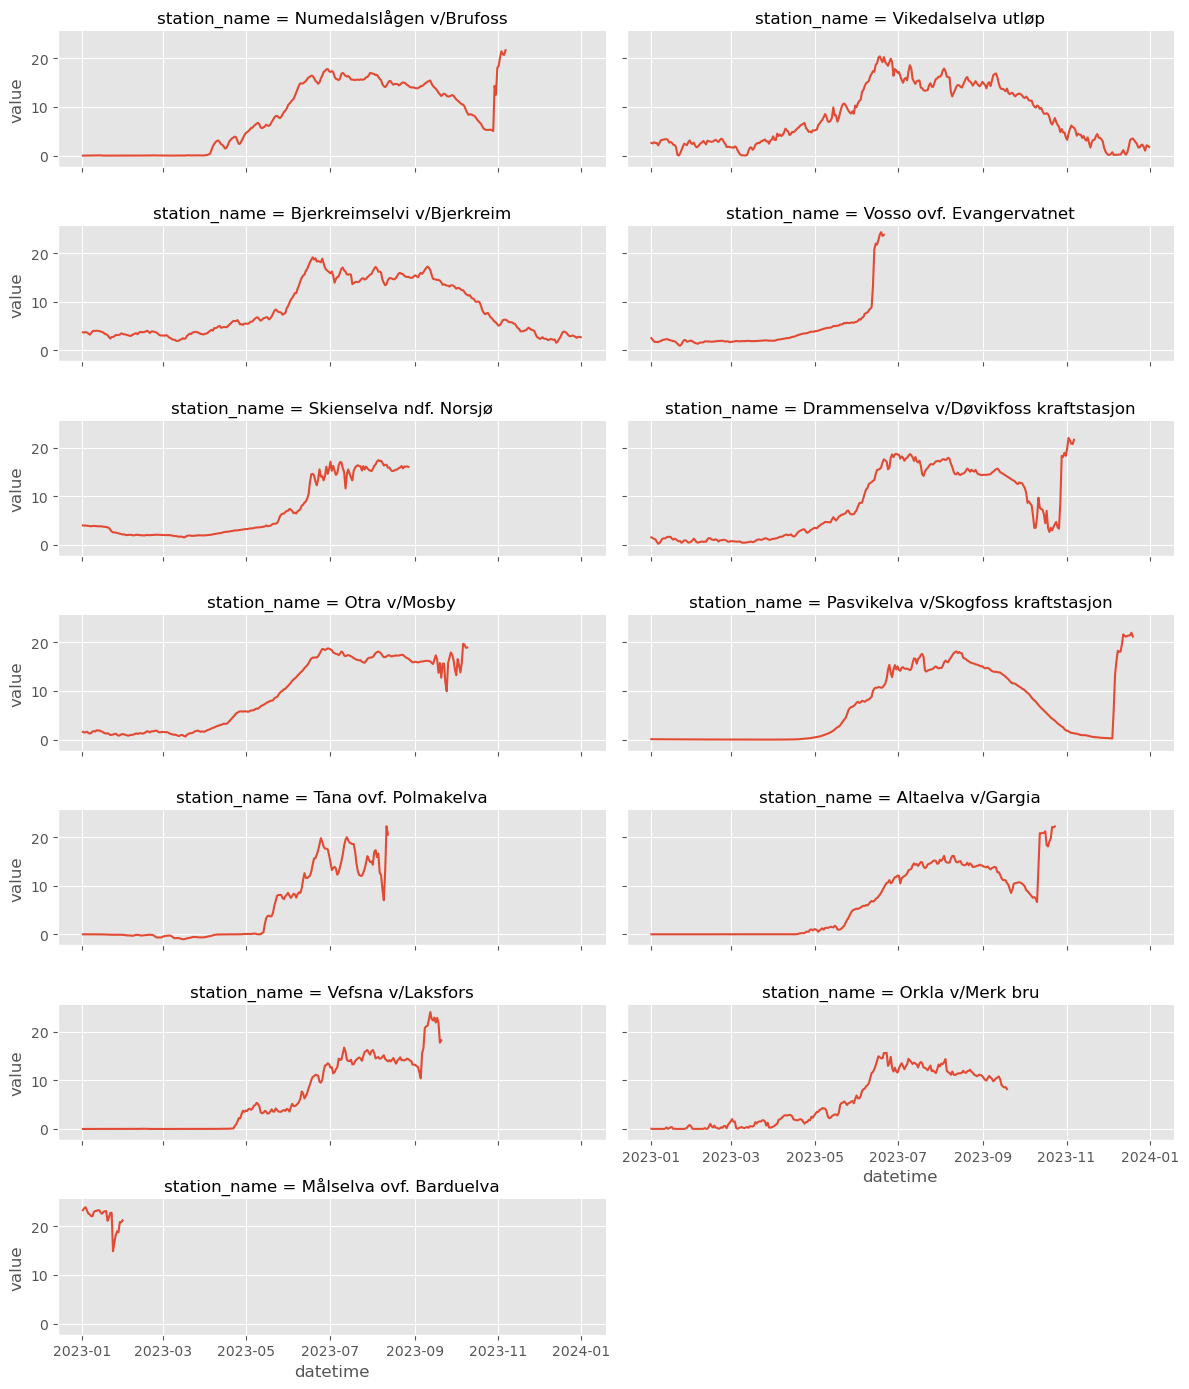

In [8]:
# Plot
sn.relplot(
    x="datetime",
    y="value",
    col="station_name",
    data=nve_df,
    kind="line",
    aspect=3,
    height=2,
    col_wrap=2,
)

## 3. Get data since 1980

In [9]:
# Get temperature data since 1980
par_ids = [1003]
st_dt = "1980-01-01"
end_dt = f"{year + 1}-01-01"

# Query in two batches to avoid API limit errors
df1 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[:7], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
df2 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[7:], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
nve_df = pd.concat([df1, df2], axis="rows")

nve_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,27.29.0,Bjerkreimselvi v/Bjerkreim,1003,Vanntemperatur,Water temperature,Mean,1986-04-24 11:00:00+00:00,4.382500,°C,0,0
1,27.29.0,Bjerkreimselvi v/Bjerkreim,1003,Vanntemperatur,Water temperature,Mean,1986-04-25 11:00:00+00:00,4.316302,°C,0,0
2,27.29.0,Bjerkreimselvi v/Bjerkreim,1003,Vanntemperatur,Water temperature,Mean,1986-04-26 11:00:00+00:00,4.231667,°C,0,0
3,27.29.0,Bjerkreimselvi v/Bjerkreim,1003,Vanntemperatur,Water temperature,Mean,1986-04-27 11:00:00+00:00,4.502864,°C,0,0
4,27.29.0,Bjerkreimselvi v/Bjerkreim,1003,Vanntemperatur,Water temperature,Mean,1986-04-28 11:00:00+00:00,4.404322,°C,0,0


In [10]:
# Check for stations with no data
no_data = set(nve_stn_df["station_id"].tolist()) - set(nve_df["station_id"].tolist())
if len(no_data) > 0:
    print(f"The following stations have no temperature data for {year}:")
    print(stn_df.query("nve_id in @no_data"))

# Check quality control level
print(
    "\n\nThe following series have not completed quality control "
    "(i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):\n"
)
print(nve_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Check for NaN
if pd.isna(nve_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        nve_df[pd.isna(nve_df["value"])][
            ["station_id", "station_name"]
        ].drop_duplicates()
    )



The following series have not completed quality control (i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):

      station_id                           station_name
0        27.29.0             Bjerkreimselvi v/Bjerkreim
13766     38.2.0                     Vikedalselva utløp
35554   15.115.0                Numedalslågen v/Brufoss
46661   12.298.0  Drammenselva v/Døvikfoss kraftstasjon
60322    62.30.0               Vosso ovf. Evangervatnet
68599    21.79.0                           Otra v/Mosby
82394   16.207.0                 Skienselva ndf. Norsjø
0       212.68.0                      Altaelva v/Gargia
15744   234.19.0                   Tana ovf. Polmakelva
27834   246.11.0     Pasvikelva v/Skogfoss kraftstasjon
39803   196.43.0                Målselva ovf. Barduelva
52107    84.23.0                    Nausta v/Hovefossen
64138   121.62.0                       Orkla v/Merk bru
76736   151.32.0                      Vefsna v/Laksfors


The following recor

In [11]:
# Get first and last years
nve_df.groupby("station_id").agg({"datetime": ["min", "max"]})

datetime                          
                                 min                       max
station_id                                                    
12.298.0   1986-12-19 11:00:00+00:00 2023-11-06 11:00:00+00:00
121.62.0   1989-03-23 11:00:00+00:00 2023-09-18 11:00:00+00:00
15.115.0   1984-11-15 11:00:00+00:00 2023-11-06 11:00:00+00:00
151.32.0   1993-09-08 11:00:00+00:00 2023-09-20 11:00:00+00:00
16.207.0   1989-11-24 11:00:00+00:00 2023-08-27 11:00:00+00:00
196.43.0   1989-05-25 11:00:00+00:00 2023-01-30 11:00:00+00:00
21.79.0    1986-01-02 11:00:00+00:00 2023-10-09 11:00:00+00:00
212.68.0   1980-09-15 11:00:00+00:00 2023-10-23 11:00:00+00:00
234.19.0   1990-07-07 11:00:00+00:00 2023-08-12 11:00:00+00:00
246.11.0   1991-03-14 11:00:00+00:00 2023-12-19 11:00:00+00:00
27.29.0    1986-04-24 11:00:00+00:00 2023-12-31 11:00:00+00:00
38.2.0     1985-10-13 11:00:00+00:00 2023-12-31 11:00:00+00:00
62.30.0    1987-06-04 11:00:00+00:00 2023-06-20 11:00:00+00:00
84.23.0    1989-12-07 11:00:00+00:00 2022-11-14 11:00:00+00:00

## 4. Trend analysis

The code below loops over each daily resolution temperature file and performs the following calculations:

 1. Resample to annual resolution by taking the mean, and count the number of non-null measurements in each year.
 
 2. Filter out years with less than $(prop \times 365)$ data points
 
 3. Write the annual results to a new worksheet in an Excel file
 
 4. Perform the Mann-Kendall and Sen's Slope tests on the annual data and print summary results
 
 5. Plot the fitted Sen's slope against the raw data values and save the plot as a PNG.

In [12]:
# Prepare to write Excel workbook
writer = pd.ExcelWriter(out_xlsx)

# Min count based on prop
min_days = prop * 365

# Loop over data
for nve_id in nve_df["station_id"].unique():
    df = nve_df.query("station_id == @nve_id").copy()
    df = df.set_index("datetime")[["value"]]

    # Resample (counts and avgs)
    cnt_df = df.resample("A").count()
    avg_df = df.resample("A").mean()

    # Join
    df = avg_df.join(cnt_df, lsuffix="", rsuffix="_count")

    # Filter years with insufficient data
    df = df.query("value_count > @min_days")

    # Index to years
    df.index = df.index.year

    # Save to Excel
    df.to_excel(writer, sheet_name=nve_id)

    # Run stats
    print("###################################################################")
    print("Station:", nve_id)
    print("Results based on %s years with data" % len(df))
    print("###################################################################")

    # Mann-Kendall
    print("M-K test:")
    mk_df = nivapy.stats.mk_test(df, "value")
    print(mk_df)
    print("")

    # Sen's slope
    print("Sen's slope:")
    res_df, sen_df = nivapy.stats.sens_slope(df, value_col="value", index_col=df.index)
    print(res_df)
    print("###################################################################")
    print("")

    # Plot
    nivapy.plotting.plot_sens_slope(
        res_df, sen_df, ylabel="Avg. temp. (C)", title="Station %s" % nve_id
    )
    out_png = os.path.join(png_fold, "sens_slp_%s.png" % nve_id)
    plt.savefig(out_png, dpi=300)
    plt.close()
writer.close()

###################################################################
Station: 27.29.0
Results based on 33 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  4165.333333
s                    M-K test statistic        218.0
z             Normalised test statistic     3.362288
p      p-value of the significance test     0.000773
trend        Type of trend (if present)   increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.039235
icpt                                Estimated intercept  -70.466157
lb     Lower bound on slope estimate at specified alpha    0.017096
ub     Upper bound on slope estimate at specified alpha    0.068016
trend                        Type of trend (if present)  increasing
#############################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()
/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 38.2.0
Results based on 34 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  4550.333333
s                    M-K test statistic        175.0
z             Normalised test statistic     2.579453
p      p-value of the significance test     0.009896
trend        Type of trend (if present)   increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.020018
icpt                                Estimated intercept  -32.349382
lb     Lower bound on slope estimate at specified alpha    0.004572
ub     Upper bound on slope estimate at specified alpha    0.034111
trend                        Type of trend (if present)  increasing
##############################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 15.115.0
Results based on 17 years with data
###################################################################
M-K test:
                            description       value
var_s        Variance of test statistic  589.333333
s                    M-K test statistic        28.0
z             Normalised test statistic    1.112201
p      p-value of the significance test    0.266052
trend        Type of trend (if present)    no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate   0.026859
icpt                                Estimated intercept -46.742246
lb     Lower bound on slope estimate at specified alpha  -0.028615
ub     Upper bound on slope estimate at specified alpha   0.071714
trend                        Type of trend (if present)   no trend
###################################################################



/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 12.298.0
Results based on 25 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  1833.333333
s                    M-K test statistic        136.0
z             Normalised test statistic     3.152921
p      p-value of the significance test     0.001616
trend        Type of trend (if present)   increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.030479
icpt                                Estimated intercept  -53.532802
lb     Lower bound on slope estimate at specified alpha    0.011954
ub     Upper bound on slope estimate at specified alpha    0.052866
trend                        Type of trend (if present)  increasing
############################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 62.30.0
Results based on 23 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  1433.666667
s                    M-K test statistic         69.0
z             Normalised test statistic     1.795911
p      p-value of the significance test     0.072509
trend        Type of trend (if present)     no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate   0.023411
icpt                                Estimated intercept -40.746371
lb     Lower bound on slope estimate at specified alpha  -0.001568
ub     Upper bound on slope estimate at specified alpha   0.046504
trend                        Type of trend (if present)   no trend
###################################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 21.79.0
Results based on 27 years with data
###################################################################
M-K test:
                            description       value
var_s        Variance of test statistic      2301.0
s                    M-K test statistic       121.0
z             Normalised test statistic    2.501629
p      p-value of the significance test    0.012362
trend        Type of trend (if present)  increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.024139
icpt                                Estimated intercept  -40.333959
lb     Lower bound on slope estimate at specified alpha    0.005879
ub     Upper bound on slope estimate at specified alpha    0.044991
trend                        Type of trend (if present)  increasing
###################################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 16.207.0
Results based on 26 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  2058.333333
s                    M-K test statistic        127.0
z             Normalised test statistic     2.777235
p      p-value of the significance test     0.005482
trend        Type of trend (if present)   increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.028178
icpt                                Estimated intercept  -48.542535
lb     Lower bound on slope estimate at specified alpha    0.009094
ub     Upper bound on slope estimate at specified alpha    0.044182
trend                        Type of trend (if present)  increasing
############################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 212.68.0
Results based on 29 years with data
###################################################################
M-K test:
                            description       value
var_s        Variance of test statistic      2842.0
s                    M-K test statistic       176.0
z             Normalised test statistic    3.282661
p      p-value of the significance test    0.001028
trend        Type of trend (if present)  increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.019807
icpt                                Estimated intercept  -35.179143
lb     Lower bound on slope estimate at specified alpha    0.008219
ub     Upper bound on slope estimate at specified alpha     0.03337
trend                        Type of trend (if present)  increasing
##################################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 234.19.0
Results based on 19 years with data
###################################################################
M-K test:
                            description     value
var_s        Variance of test statistic     817.0
s                    M-K test statistic      -9.0
z             Normalised test statistic -0.279885
p      p-value of the significance test  0.779566
trend        Type of trend (if present)  no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate  -0.006223
icpt                                Estimated intercept  16.786999
lb     Lower bound on slope estimate at specified alpha  -0.032011
ub     Upper bound on slope estimate at specified alpha   0.024761
trend                        Type of trend (if present)   no trend
###################################################################



/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 246.11.0
Results based on 27 years with data
###################################################################
M-K test:
                            description       value
var_s        Variance of test statistic      2301.0
s                    M-K test statistic       151.0
z             Normalised test statistic    3.127036
p      p-value of the significance test    0.001766
trend        Type of trend (if present)  increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.036835
icpt                                Estimated intercept   -68.94898
lb     Lower bound on slope estimate at specified alpha    0.013745
ub     Upper bound on slope estimate at specified alpha      0.0605
trend                        Type of trend (if present)  increasing
##################################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 196.43.0
Results based on 17 years with data
###################################################################
M-K test:
                            description       value
var_s        Variance of test statistic  589.333333
s                    M-K test statistic        24.0
z             Normalised test statistic     0.94743
p      p-value of the significance test    0.343419
trend        Type of trend (if present)    no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate   0.018416
icpt                                Estimated intercept -33.187498
lb     Lower bound on slope estimate at specified alpha   -0.02787
ub     Upper bound on slope estimate at specified alpha    0.05516
trend                        Type of trend (if present)   no trend
###################################################################



/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 84.23.0
Results based on 19 years with data
###################################################################
M-K test:
                            description     value
var_s        Variance of test statistic     817.0
s                    M-K test statistic      13.0
z             Normalised test statistic  0.419827
p      p-value of the significance test  0.674612
trend        Type of trend (if present)  no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate   0.009087
icpt                                Estimated intercept -12.376308
lb     Lower bound on slope estimate at specified alpha  -0.033861
ub     Upper bound on slope estimate at specified alpha   0.078526
trend                        Type of trend (if present)   no trend
###################################################################



/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 121.62.0
Results based on 26 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  2058.333333
s                    M-K test statistic         59.0
z             Normalised test statistic      1.27841
p      p-value of the significance test     0.201105
trend        Type of trend (if present)     no trend

Sen's slope:
                                            description      value
sslp                              Median slope estimate    0.01017
icpt                                Estimated intercept -15.650754
lb     Lower bound on slope estimate at specified alpha  -0.007719
ub     Upper bound on slope estimate at specified alpha   0.026767
trend                        Type of trend (if present)   no trend
##################################################################

/tmp/ipykernel_1849/3405548522.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  cnt_df = df.resample("A").count()
/tmp/ipykernel_1849/3405548522.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  avg_df = df.resample("A").mean()


###################################################################
Station: 151.32.0
Results based on 4 years with data
###################################################################
M-K test:
                            description     value
var_s        Variance of test statistic  8.666667
s                    M-K test statistic      -2.0
z             Normalised test statistic -0.339683
p      p-value of the significance test  0.734095
trend        Type of trend (if present)  no trend

Sen's slope:
                                            description       value
sslp                              Median slope estimate   -0.074919
icpt                                Estimated intercept  155.547693
lb     Lower bound on slope estimate at specified alpha   -1.114058
ub     Upper bound on slope estimate at specified alpha    0.048287
trend                        Type of trend (if present)    no trend
###################################################################

